# Relative Depth 시각화하기

## `dataloader` > `BatvisionV2_Dataset.py`

In [10]:
locations = [
    "2ndFloorLuxembourg",
    "3rd_Floor_Luxembourg",
    "Attic",
    "Outdoor_Cobblestone_Path",
    "Salle_Chevalier",
    "Salle_des_Colonnes",
    "V119_Cake_Corridors"
]

In [21]:
def _load_image(image_path):
    # Load image using cv2 (BGR format)
    image = cv2.imread(image_path)
    if image is None:
        raise RuntimeError(f"Could not load image file {image_path}")
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Keep as uint8 [0, 255] for ToTensor() to work correctly
    # ToTensor() will automatically convert uint8 [0, 255] -> float32 [0, 1]
    # and transpose from (H, W, C) to (C, H, W)
    
    # Apply transforms (resize, etc.)
    # convert=True will use ToTensor() which handles normalization
    image_transform = get_transform( convert=True, depth_norm=False) #self.cfg,
    image_tensor = image_transform(image) 
    
    return image_tensor

In [22]:

import torch
import torchvision.transforms as transforms

import os, glob
import pandas as pd
import numpy as np


def get_transform(convert =  False, depth_norm = False):
    # Create list of transform to apply to data
    transform_list = []

    if convert:
        # Convert data to Tensor type
        transform_list += [transforms.ToTensor()]

    if 'resize' in ['resize']:
        # Resize
        transform_list.append(transforms.Resize((256,256)))

    if depth_norm:
        # MinMax depth normalization
        max_depth_dataset = 80 
        min_depth_dataset = 0.0
        transform_list += [MinMaxNorm(min = min_depth_dataset, max = max_depth_dataset)]

    return transforms.Compose(transform_list)


In [25]:
import os
import torch
import pandas as pd
import torchaudio
import cv2
import torchaudio.transforms as T
from torch.utils.data import Dataset
import numpy as np

for location in locations[:1]:
    csv_fnames = pd.read_csv(f'/root/dev/data/dataset/Batvision/BatvisionV2/{location}/train.csv')
    fnumbers = len(csv_fnames)

    for i in range(fnumbers):
        item = csv_fnames.iloc[i]
        root_dir = '/root/dev/data/dataset/Batvision/BatvisionV2/'
        max_depth = 30.0

        '''
        index                                        0
        time                          1662459158.49745
        left audio time               1662459158.49745
        right audio time              1662459158.49745
        audio path           2ndFloorLuxembourg/audio/
        audio file name                    audio_0.wav
        camera time                  1662459158.455387
        camera path         2ndFloorLuxembourg/camera/
        camera file name                 camera_0.jpeg
        depth time                   1662459158.455387
        depth path           2ndFloorLuxembourg/depth/
        depth file name                    depth_0.npy
        Name: 0, dtype: object
        '''

        depth_filename = item['depth file name']
        audio_filename = item['audio file name']
        image_filename = item['camera file name']

        depth_path = os.path.join(root_dir, item['depth path'], depth_filename)
        audio_path = os.path.join(root_dir, item['audio path'], audio_filename)
        image_path = os.path.join(root_dir, item['camera path'], image_filename)

        # Audio
        waveform, sr = torchaudio.load(audio_path)
        # waveform : [2, 20000]
        # sr : 44100 (scalar)

        # Image


        # Depth
        depth = np.load(depth_path).astype(np.float32) # min (np.float32(0.0), max np.float32(11929.0))
        depth = depth / 1000 # to go from mm to m
        depth[depth > max_depth] = max_depth # 0.0 to 11.929 (m)
        #print(depth.min(), depth.max())

        #print(np.sum(depth == 0.0) / np.sum(depth > 0))


        image_filename = item['camera file name']
        image_path = os.path.join(root_dir, item['camera path'], image_filename)
        input_data = _load_image(image_path)

        #To tensor
        #Min-max normalize


In [28]:
torch.max(input_data), torch.min(input_data)

(tensor(1.0000), tensor(0.0002))

In [29]:
input_data.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022692395..1.0000001].


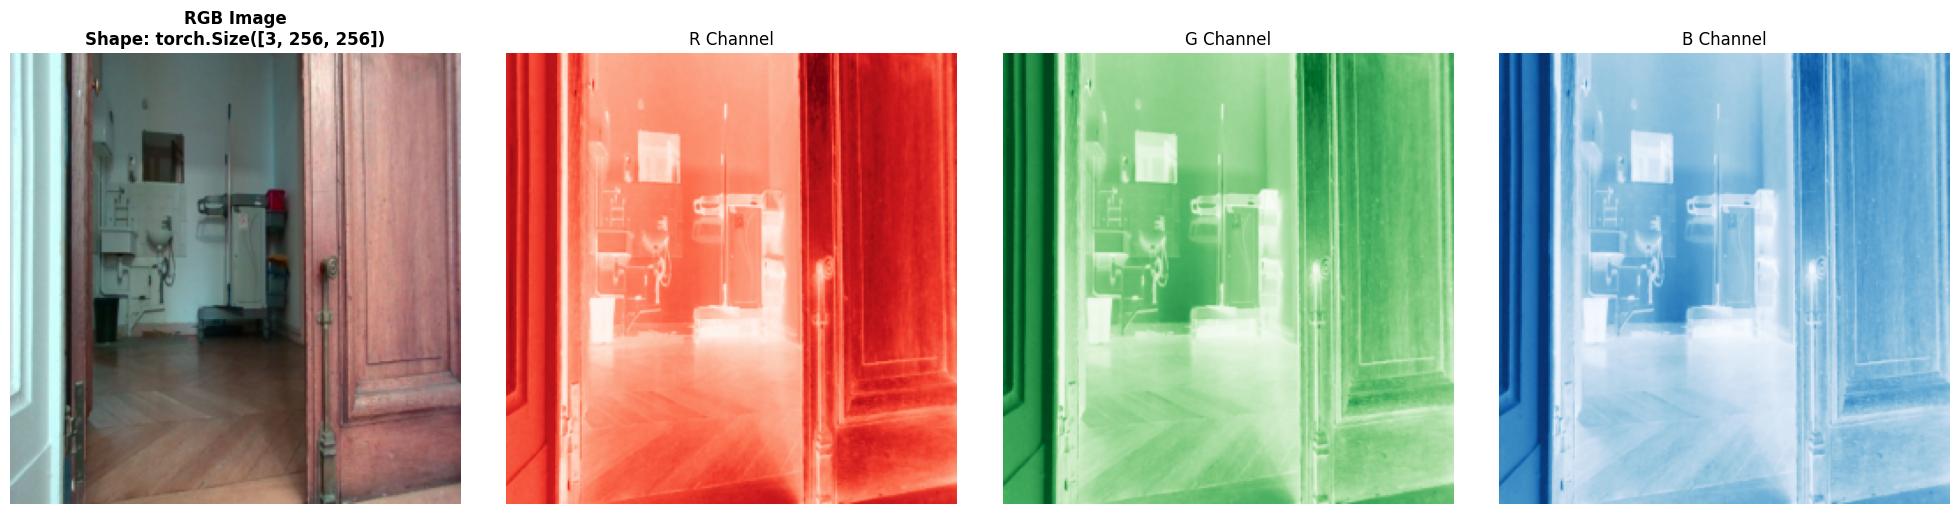

Input data shape: torch.Size([3, 256, 256])
Value range: [0.0002, 1.0000]
Mean: 0.4682, Std: 0.2012


In [30]:
# input_data 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# RGB 이미지 전체 시각화
img_rgb = input_data.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
axes[0].imshow(img_rgb)
axes[0].set_title(f'RGB Image\nShape: {input_data.shape}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# R, G, B 각 채널 시각화
channel_names = ['R Channel', 'G Channel', 'B Channel']
channel_cmaps = ['Reds', 'Greens', 'Blues']

for i in range(3):
    axes[i+1].imshow(input_data[i].numpy(), cmap=channel_cmaps[i])
    axes[i+1].set_title(channel_names[i], fontsize=12)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print(f"Input data shape: {input_data.shape}")
print(f"Value range: [{input_data.min():.4f}, {input_data.max():.4f}]")
print(f"Mean: {input_data.mean():.4f}, Std: {input_data.std():.4f}")


In [51]:
np.sum(depth[depth == 0.0])

np.float32(0.0)

In [34]:
sr

44100

In [15]:
depth = np.load(depth_path).astype(np.float32)
depth.min(), depth.max()

(np.float32(0.0), np.float32(11929.0))

## `train.py` 

# 데이터 시각화하기

In [18]:
# ============================================================================
# Cell 1: Imports
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import uniform_filter, gaussian_filter
from skimage.segmentation import slic
from skimage.measure import regionprops

In [19]:
# ============================================================================
# Cell 2: 기본 Smoothing 함수 정의
# ============================================================================

def fill_holes_completely(depth, invalid_value=0.0):
    """구멍을 완전히 채우는 함수 (inpainting + morphological closing)"""
    mask = (depth > invalid_value) & ~np.isnan(depth)
    depth_filled = depth.copy().astype(np.float32)
    
    if mask.all():
        return depth_filled
    
    mask_uint8 = (~mask).astype(np.uint8) * 255
    depth_filled = cv2.inpaint(depth_filled, mask_uint8, 10, cv2.INPAINT_TELEA)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    depth_filled = cv2.morphologyEx(depth_filled, cv2.MORPH_CLOSE, kernel)
    
    return depth_filled


def smooth_heavy_downup(depth, scale=0.1, invalid_value=0.0):
    """매우 강한 다운샘플링으로 디테일 제거 + 구멍 채우기"""
    H, W = depth.shape
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    h_small = max(1, int(H * scale))
    w_small = max(1, int(W * scale))
    depth_small = cv2.resize(depth_filled, (w_small, h_small), interpolation=cv2.INTER_AREA)
    depth_coarse = cv2.resize(depth_small, (W, H), interpolation=cv2.INTER_LINEAR)
    
    return depth_coarse


def smooth_superpixel(depth, n_segments=200, compactness=10, invalid_value=0.0):
    """Superpixel 기반 단순화 - 각 영역을 대표 depth로 표현"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    
    segments = slic(depth_3ch, n_segments=n_segments, compactness=compactness, 
                    start_label=0, channel_axis=-1)
    
    depth_simplified = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_simplified[mask] = depth_filled[mask].mean()
    
    return depth_simplified


def smooth_quantized(depth, n_levels=8, invalid_value=0.0):
    """Depth를 N개의 대표 값으로 양자화"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    valid_mask = depth_filled > invalid_value
    if not valid_mask.any():
        return depth_filled
    
    min_d, max_d = depth_filled[valid_mask].min(), depth_filled[valid_mask].max()
    bins = np.linspace(min_d, max_d, n_levels + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    indices = np.digitize(depth_filled, bins) - 1
    indices = np.clip(indices, 0, n_levels - 1)
    depth_quantized = bin_centers[indices]
    depth_quantized = cv2.GaussianBlur(depth_quantized.astype(np.float32), (5, 5), 1.5)
    
    return depth_quantized


def smooth_iterative_inpaint_blur(depth, iterations=3, blur_sigma=5.0, invalid_value=0.0):
    """반복적 inpainting + 강한 블러로 구멍 채우고 단순화"""
    depth_result = depth.copy().astype(np.float32)
    
    for i in range(iterations):
        mask = (depth_result <= invalid_value) | np.isnan(depth_result)
        if mask.any():
            mask_uint8 = mask.astype(np.uint8) * 255
            depth_result = cv2.inpaint(depth_result, mask_uint8, 5, cv2.INPAINT_TELEA)
        
        kernel_size = int(blur_sigma * 4) | 1
        depth_result = cv2.GaussianBlur(depth_result, (kernel_size, kernel_size), blur_sigma)
    
    return depth_result


def smooth_planar_fit(depth, grid_size=32, invalid_value=0.0):
    """그리드 영역별 평면 fitting으로 단순화"""
    H, W = depth.shape
    depth_filled = fill_holes_completely(depth, invalid_value)
    depth_planar = np.zeros_like(depth_filled)
    
    for i in range(0, H, grid_size):
        for j in range(0, W, grid_size):
            i_end = min(i + grid_size, H)
            j_end = min(j + grid_size, W)
            block = depth_filled[i:i_end, j:j_end]
            depth_planar[i:i_end, j:j_end] = block.mean()
    
    depth_planar = cv2.GaussianBlur(depth_planar.astype(np.float32), (15, 15), 3.0)
    return depth_planar


print('기본 smoothing 함수 정의 완료!')

기본 smoothing 함수 정의 완료!


In [20]:
# ============================================================================
# Cell 3: Superpixel 변형 함수들
# ============================================================================

def smooth_superpixel_extreme(depth, n_segments=30, compactness=30, blur_sigma=3.0, invalid_value=0.0):
    """극단적으로 단순화된 Superpixel - 매우 적은 세그먼트 + 후처리 블러"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    
    segments = slic(depth_3ch, n_segments=n_segments, compactness=compactness, 
                    start_label=0, channel_axis=-1)
    
    depth_simplified = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_simplified[mask] = depth_filled[mask].mean()
    
    if blur_sigma > 0:
        kernel_size = int(blur_sigma * 4) | 1
        depth_simplified = cv2.GaussianBlur(depth_simplified.astype(np.float32), 
                                            (kernel_size, kernel_size), blur_sigma)
    
    return depth_simplified


def smooth_superpixel_hierarchical(depth, levels=[200, 50, 15], invalid_value=0.0):
    """계층적 Superpixel - 여러 단계로 점진적 단순화"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    depth_result = depth_filled.copy()
    
    for n_seg in levels:
        depth_norm = (depth_result - depth_result.min()) / (depth_result.max() - depth_result.min() + 1e-8)
        depth_3ch = np.stack([depth_norm] * 3, axis=-1)
        
        segments = slic(depth_3ch, n_segments=n_seg, compactness=20, 
                        start_label=0, channel_axis=-1)
        
        for region_id in np.unique(segments):
            mask = segments == region_id
            depth_result[mask] = depth_result[mask].mean()
    
    return depth_result


def smooth_superpixel_quantized(depth, n_segments=100, n_depth_levels=5, invalid_value=0.0):
    """Superpixel + Depth 양자화 결합"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_norm = (depth_filled - depth_filled.min()) / (depth_filled.max() - depth_filled.min() + 1e-8)
    depth_3ch = np.stack([depth_norm] * 3, axis=-1)
    segments = slic(depth_3ch, n_segments=n_segments, compactness=15, 
                    start_label=0, channel_axis=-1)
    
    depth_sp = np.zeros_like(depth_filled)
    for region_id in np.unique(segments):
        mask = segments == region_id
        depth_sp[mask] = depth_filled[mask].mean()
    
    min_d, max_d = depth_sp.min(), depth_sp.max()
    bins = np.linspace(min_d, max_d, n_depth_levels + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    indices = np.digitize(depth_sp, bins) - 1
    indices = np.clip(indices, 0, n_depth_levels - 1)
    depth_quantized = bin_centers[indices]
    
    return depth_quantized


print('Superpixel 변형 함수 정의 완료!')

Superpixel 변형 함수 정의 완료!


In [ ]:
# ============================================================================
# Cell 4: Binning 함수들 (Classification용)
# ============================================================================

def depth_to_bins(depth, n_bins=128, depth_min=None, depth_max=None, invalid_value=0.0):
    """Depth를 N개의 bin (class label)로 변환 - Linear"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    if depth_min is None:
        depth_min = depth_filled[depth_filled > invalid_value].min()
    if depth_max is None:
        depth_max = depth_filled.max()
    
    bins = np.linspace(depth_min, depth_max, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def depth_to_bins_log(depth, n_bins=128, invalid_value=0.0):
    """Log-scale binning - 가까운 거리에 더 많은 bin 할당"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_min = depth_filled[depth_filled > invalid_value].min()
    depth_max = depth_filled.max()
    
    bins = np.logspace(np.log10(depth_min), np.log10(depth_max), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def depth_to_bins_sid(depth, n_bins=128, alpha=0.5, invalid_value=0.0):
    """SID (Spacing-Increasing Discretization) - DORN paper 방식"""
    depth_filled = fill_holes_completely(depth, invalid_value)
    
    depth_min = depth_filled[depth_filled > invalid_value].min()
    depth_max = depth_filled.max()
    
    t = np.linspace(0, 1, n_bins + 1)
    bins = depth_min * (depth_max / depth_min) ** (t ** alpha)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_indices = np.digitize(depth_filled, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    return bin_indices, bin_centers, bins


def bins_to_depth(bin_indices, bin_centers):
    """Bin indices를 다시 depth 값으로 변환"""
    return bin_centers[bin_indices]


def smooth_binned(depth, n_bins=128, pre_smooth=None, post_blur=0, invalid_value=0.0):
    """Bin 기반 단순화 + 선택적 전/후처리"""
    depth_processed = depth.copy().astype(np.float32)
    
    if pre_smooth == 'downup':
        depth_processed = smooth_heavy_downup(depth_processed, scale=0.1)
    elif pre_smooth == 'superpixel':
        depth_processed = smooth_superpixel(depth_processed, n_segments=100)
    
    bin_indices, bin_centers, _ = depth_to_bins(depth_processed, n_bins=n_bins)
    depth_binned = bins_to_depth(bin_indices, bin_centers)
    
    if post_blur > 0:
        kernel_size = int(post_blur * 4) | 1
        depth_binned = cv2.GaussianBlur(depth_binned.astype(np.float32), 
                                        (kernel_size, kernel_size), post_blur)
    
    return depth_binned, bin_indices


print('Binning 함수 정의 완료!')

Binning 함수 정의 완료!


In [ ]:
# ============================================================================
# Cell 5: 데이터 로드
# ============================================================================

base_path = '/root/dev/data/dataset/Batvision/BatvisionV2/2ndFloorLuxembourg'
file_idx = 0

# 원본 depth 로드
depth_original = np.load(f'{base_path}/depth/depth_{file_idx}.npy').astype(np.float32)

# 컬러 범위 설정
valid_mask = depth_original > 0
vmin, vmax = depth_original[valid_mask].min(), depth_original[valid_mask].max()

print(f'Depth loaded: {depth_original.shape}')
print(f'Valid range: {vmin:.1f} ~ {vmax:.1f}')

Depth loaded: (720, 1280)
Valid range: 629.0 ~ 11929.0


30개 방법 계산 중...
30개 방법 준비 완료!


/tmp/ipykernel_885200/97508363.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.99])


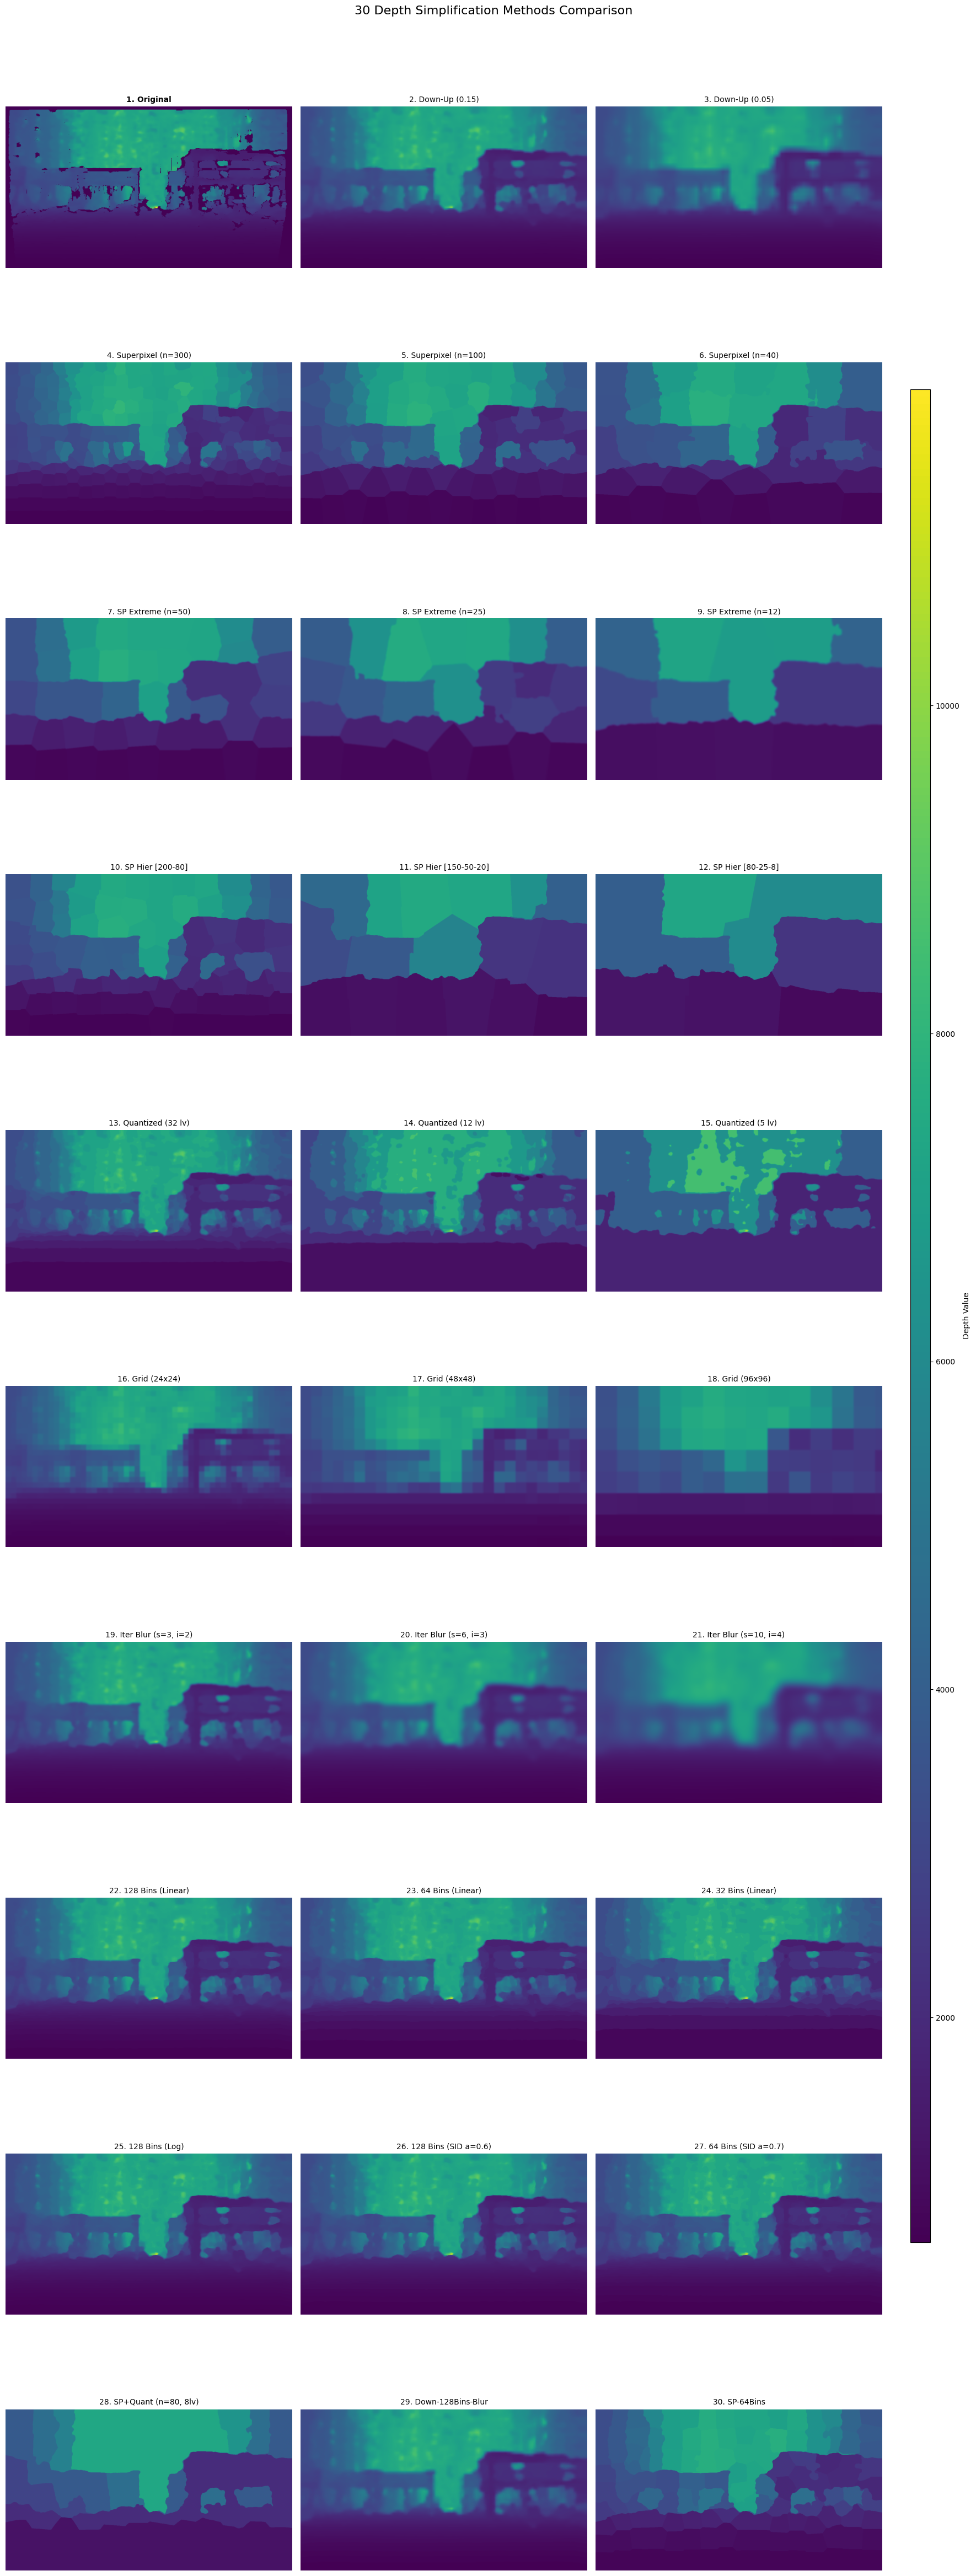


all_30_methods.png 저장 완료!


In [ ]:
# ============================================================================
# Cell 6: 전체 30개 방법 종합 시각화 (10 x 3 Grid)
# ============================================================================

print('30개 방법 계산 중...')

all_30_methods = [
    # Row 1: Original + Down-Up
    ('1. Original', depth_original),
    ('2. Down-Up (0.15)', smooth_heavy_downup(depth_original, scale=0.15)),
    ('3. Down-Up (0.05)', smooth_heavy_downup(depth_original, scale=0.05)),
    
    # Row 2: Superpixel 기본
    ('4. Superpixel (n=300)', smooth_superpixel(depth_original, n_segments=300)),
    ('5. Superpixel (n=100)', smooth_superpixel(depth_original, n_segments=100)),
    ('6. Superpixel (n=40)', smooth_superpixel(depth_original, n_segments=40)),
    
    # Row 3: Superpixel Extreme
    ('7. SP Extreme (n=50)', smooth_superpixel_extreme(depth_original, n_segments=50, blur_sigma=2.0)),
    ('8. SP Extreme (n=25)', smooth_superpixel_extreme(depth_original, n_segments=25, blur_sigma=3.0)),
    ('9. SP Extreme (n=12)', smooth_superpixel_extreme(depth_original, n_segments=12, blur_sigma=4.0)),
    
    # Row 4: Superpixel Hierarchical
    ('10. SP Hier [200-80]', smooth_superpixel_hierarchical(depth_original, levels=[200, 80])),
    ('11. SP Hier [150-50-20]', smooth_superpixel_hierarchical(depth_original, levels=[150, 50, 20])),
    ('12. SP Hier [80-25-8]', smooth_superpixel_hierarchical(depth_original, levels=[80, 25, 8])),
    
    # Row 5: Quantization
    ('13. Quantized (32 lv)', smooth_quantized(depth_original, n_levels=32)),
    ('14. Quantized (12 lv)', smooth_quantized(depth_original, n_levels=12)),
    ('15. Quantized (5 lv)', smooth_quantized(depth_original, n_levels=5)),
    
    # Row 6: Planar Grid
    ('16. Grid (24x24)', smooth_planar_fit(depth_original, grid_size=24)),
    ('17. Grid (48x48)', smooth_planar_fit(depth_original, grid_size=48)),
    ('18. Grid (96x96)', smooth_planar_fit(depth_original, grid_size=96)),
    
    # Row 7: Iterative Blur
    ('19. Iter Blur (s=3, i=2)', smooth_iterative_inpaint_blur(depth_original, iterations=2, blur_sigma=3.0)),
    ('20. Iter Blur (s=6, i=3)', smooth_iterative_inpaint_blur(depth_original, iterations=3, blur_sigma=6.0)),
    ('21. Iter Blur (s=10, i=4)', smooth_iterative_inpaint_blur(depth_original, iterations=4, blur_sigma=10.0)),
    
    # Row 8: Binning (Linear)
    ('22. 128 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=128)[:2])),
    ('23. 64 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=64)[:2])),
    ('24. 32 Bins (Linear)', bins_to_depth(*depth_to_bins(depth_original, n_bins=32)[:2])),
    
    # Row 9: Binning (Log/SID)
    ('25. 128 Bins (Log)', bins_to_depth(*depth_to_bins_log(depth_original, n_bins=128)[:2])),
    ('26. 128 Bins (SID a=0.6)', bins_to_depth(*depth_to_bins_sid(depth_original, n_bins=128, alpha=0.6)[:2])),
    ('27. 64 Bins (SID a=0.7)', bins_to_depth(*depth_to_bins_sid(depth_original, n_bins=64, alpha=0.7)[:2])),
    
    # Row 10: Combined
    ('28. SP+Quant (n=80, 8lv)', smooth_superpixel_quantized(depth_original, n_segments=80, n_depth_levels=8)),
    ('29. Down-128Bins-Blur', smooth_binned(depth_original, n_bins=128, pre_smooth='downup', post_blur=2.0)[0]),
    ('30. SP-64Bins', smooth_binned(smooth_superpixel(depth_original, n_segments=150), n_bins=64)[0]),
]

print(f'{len(all_30_methods)}개 방법 준비 완료!')

# 10 x 3 그리드 시각화
fig, axes = plt.subplots(10, 3, figsize=(18, 48))
axes = axes.flatten()

for idx, (ax, (name, data)) in enumerate(zip(axes, all_30_methods)):
    im = ax.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(name, fontsize=10, fontweight='bold' if idx == 0 else 'normal')
    ax.axis('off')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Depth Value')

plt.suptitle('30 Depth Simplification Methods Comparison', fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0, 0.9, 0.99])
plt.savefig('all_30_methods.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nall_30_methods.png 저장 완료!')

In [ ]:
# ============================================================================
# Cell 7: 30개 방법 요약표
# ============================================================================

summary = '''
============================================================================
                   30개 Depth 단순화 방법 요약
============================================================================

Row 1: Down-Up (다운샘플링)
  - Original -> scale=0.15 -> scale=0.05
  - 공간적 해상도 감소, 저주파 보존

Row 2: Superpixel (영역 기반)
  - n=300 -> n=100 -> n=40
  - 유사 depth 영역으로 분할, 각 영역 평균 depth

Row 3: SP Extreme (강한 영역화 + Blur)
  - n=50 -> n=25 -> n=12
  - 적은 영역 + 후처리 블러로 경계 부드럽게

Row 4: SP Hierarchical (계층적)
  - [200-80] -> [150-50-20] -> [80-25-8]
  - 다단계 점진적 단순화

Row 5: Quantization (depth 이산화)
  - 32 levels -> 12 levels -> 5 levels
  - depth 값을 N개 대표값으로 양자화

Row 6: Planar Grid (블록 기반)
  - 24x24 -> 48x48 -> 96x96
  - 고정 그리드로 분할, 블록당 평균값

Row 7: Iterative Blur (반복 블러)
  - (s=3,i=2) -> (s=6,i=3) -> (s=10,i=4)
  - 구멍 채우기 + 강한 가우시안 블러

Row 8: Binning Linear (균등 분할)
  - 128 bins -> 64 bins -> 32 bins
  - 균등한 bin 폭, Classification용

Row 9: Binning Log/SID (비균등 분할)
  - 128 Log -> 128 SID -> 64 SID
  - 가까운 거리에 더 촘촘한 bin

Row 10: Combined (조합)
  - SP+Quant -> Down-Bins-Blur -> SP-Bins
  - 여러 방법 결합

============================================================================
용도별 추천:
  - Coarse Classification (128 bins): #22, #25, #26, #29
  - 영역 기반 대표 depth: #5, #8, #11, #28
  - 연속적/부드러운 결과: #3, #20, #21
  - 강한 단순화 (뭉개기): #9, #12, #15, #18
============================================================================
'''

print(summary)

# 각 방법별 고유 depth 값 수 계산
print('\n각 방법별 고유 depth 값 수:')
print('-' * 50)
for i, (name, data) in enumerate(all_30_methods):
    unique_count = len(np.unique(data.round(1)))
    print(f'  {name:30s}: {unique_count:6d} unique values')


                   30개 Depth 단순화 방법 요약

Row 1: Down-Up (다운샘플링)
  - Original -> scale=0.15 -> scale=0.05
  - 공간적 해상도 감소, 저주파 보존

Row 2: Superpixel (영역 기반)
  - n=300 -> n=100 -> n=40
  - 유사 depth 영역으로 분할, 각 영역 평균 depth

Row 3: SP Extreme (강한 영역화 + Blur)
  - n=50 -> n=25 -> n=12
  - 적은 영역 + 후처리 블러로 경계 부드럽게

Row 4: SP Hierarchical (계층적)
  - [200-80] -> [150-50-20] -> [80-25-8]
  - 다단계 점진적 단순화

Row 5: Quantization (depth 이산화)
  - 32 levels -> 12 levels -> 5 levels
  - depth 값을 N개 대표값으로 양자화

Row 6: Planar Grid (블록 기반)
  - 24x24 -> 48x48 -> 96x96
  - 고정 그리드로 분할, 블록당 평균값

Row 7: Iterative Blur (반복 블러)
  - (s=3,i=2) -> (s=6,i=3) -> (s=10,i=4)
  - 구멍 채우기 + 강한 가우시안 블러

Row 8: Binning Linear (균등 분할)
  - 128 bins -> 64 bins -> 32 bins
  - 균등한 bin 폭, Classification용

Row 9: Binning Log/SID (비균등 분할)
  - 128 Log -> 128 SID -> 64 SID
  - 가까운 거리에 더 촘촘한 bin

Row 10: Combined (조합)
  - SP+Quant -> Down-Bins-Blur -> SP-Bins
  - 여러 방법 결합

용도별 추천:
  - Coarse Classification (128 bins): #22, #25, #26, #29
  - 

In [ ]:
# Debug: Check if images are being loaded correctly
import sys
sys.path.insert(0, '/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly')

from dataloader.BatvisionV2_Dataset import BatvisionV2Dataset
from config_loader import load_config
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load config
cfg = load_config(dataset_name='batvisionv2', mode='train', experiment_name='debug')

# Create datasets with and without image flag
print("Creating dataset WITH image flag (use_image=True)...")
dataset_with_image = BatvisionV2Dataset(cfg, cfg.dataset.annotation_file_train, use_image=True)

print("\nCreating dataset WITHOUT image flag (use_image=False)...")
dataset_without_image = BatvisionV2Dataset(cfg, cfg.dataset.annotation_file_train, use_image=False)

# Get first sample from both
print("\n" + "="*80)
print("Loading first sample from each dataset...")
print("="*80)

img_input, img_depth = dataset_with_image[0]
audio_input, audio_depth = dataset_without_image[0]

print(f"\nWITH use_image=True:")
print(f"  Input shape: {img_input.shape}")
print(f"  Input dtype: {img_input.dtype}")
print(f"  Input range: [{img_input.min():.4f}, {img_input.max():.4f}]")
print(f"  Input mean: {img_input.mean():.4f}")
print(f"  Depth shape: {img_depth.shape}")

print(f"\nWITH use_image=False:")
print(f"  Input shape: {audio_input.shape}")
print(f"  Input dtype: {audio_input.dtype}")
print(f"  Input range: [{audio_input.min():.4f}, {audio_input.max():.4f}]")
print(f"  Input mean: {audio_input.mean():.4f}")
print(f"  Depth shape: {audio_depth.shape}")

# Check if the inputs are actually different
if torch.allclose(img_input, audio_input):
    print("\n⚠️  WARNING: Image and audio inputs are IDENTICAL!")
    print("This means use_image flag is NOT working properly!")
else:
    print("\n✅ Image and audio inputs are DIFFERENT - use_image flag is working!")

# Additional check: verify image has 3 channels
if img_input.shape[0] == 3:
    print("✅ Image input has 3 channels (RGB) - CORRECT")
else:
    print(f"❌ Image input has {img_input.shape[0]} channels - WRONG! Should be 3")

# Check if image looks like actual RGB data
if img_input.shape[0] == 3 and img_input.min() >= 0 and img_input.max() <= 1:
    print("✅ Image input range [0, 1] - CORRECT")
else:
    print(f"⚠️  Image input range [{img_input.min():.4f}, {img_input.max():.4f}] - check if normalized correctly")


Creating dataset WITH image flag (use_image=True)...

Creating dataset WITHOUT image flag (use_image=False)...

Loading first sample from each dataset...

WITH use_image=True:
  Input shape: torch.Size([3, 256, 256])
  Input dtype: torch.float32
  Input range: [0.0000, 1.0000]
  Input mean: 0.4974
  Depth shape: torch.Size([1, 256, 256])

WITH use_image=False:
  Input shape: torch.Size([2, 256, 256])
  Input dtype: torch.float32
  Input range: [0.0523, 0.9673]
  Input mean: 0.5218
  Depth shape: torch.Size([1, 256, 256])


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


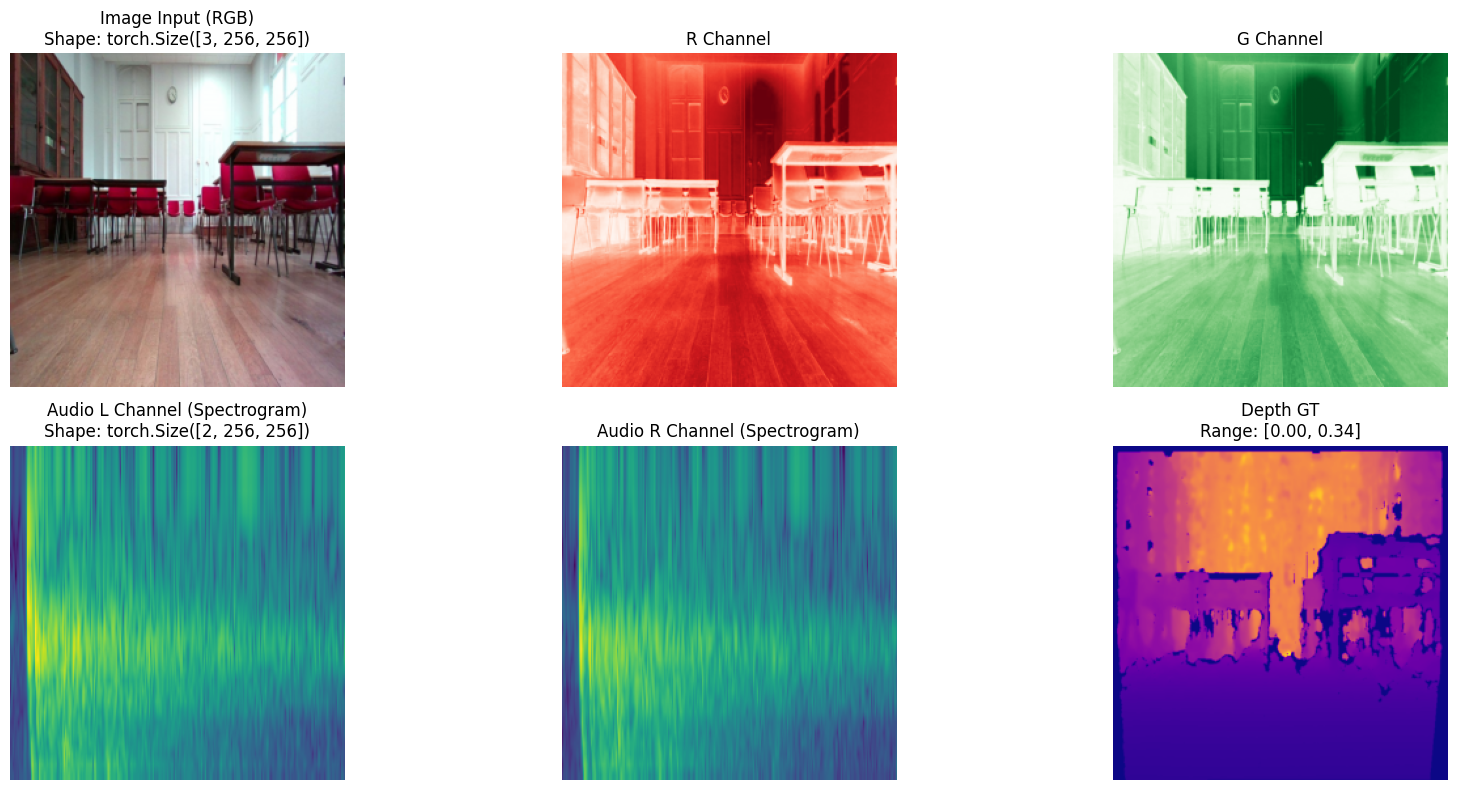


Summary:
Image input: torch.Size([3, 256, 256]) - Range [0.000, 1.000]
Audio input: torch.Size([2, 256, 256]) - Range [0.052, 0.967]
Depth GT: torch.Size([1, 256, 256]) - Range [0.000, 0.344]


In [ ]:
# Visualize the inputs
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1: Image input
if img_input.shape[0] == 3:
    # RGB image - transpose to (H, W, C) for matplotlib
    img_rgb = img_input.permute(1, 2, 0).cpu().numpy()
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title(f'Image Input (RGB)\nShape: {img_input.shape}')
    axes[0, 0].axis('off')
    
    # Show individual RGB channels
    axes[0, 1].imshow(img_input[0].cpu().numpy(), cmap='Reds')
    axes[0, 1].set_title(f'R Channel')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_input[1].cpu().numpy(), cmap='Greens')
    axes[0, 2].set_title(f'G Channel')
    axes[0, 2].axis('off')
else:
    axes[0, 0].imshow(img_input[0].cpu().numpy(), cmap='viridis')
    axes[0, 0].set_title(f'Image Input Ch0\nShape: {img_input.shape}')
    axes[0, 0].axis('off')

# Row 2: Audio input (spectrogram)
axes[1, 0].imshow(audio_input[0].cpu().numpy(), cmap='viridis')
axes[1, 0].set_title(f'Audio L Channel (Spectrogram)\nShape: {audio_input.shape}')
axes[1, 0].axis('off')

axes[1, 1].imshow(audio_input[1].cpu().numpy(), cmap='viridis')
axes[1, 1].set_title(f'Audio R Channel (Spectrogram)')
axes[1, 1].axis('off')

# Depth comparison
axes[1, 2].imshow(img_depth[0].cpu().numpy(), cmap='plasma')
axes[1, 2].set_title(f'Depth GT\nRange: [{img_depth.min():.2f}, {img_depth.max():.2f}]')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Summary:")
print("="*80)
print(f"Image input: {img_input.shape} - Range [{img_input.min():.3f}, {img_input.max():.3f}]")
print(f"Audio input: {audio_input.shape} - Range [{audio_input.min():.3f}, {audio_input.max():.3f}]")
print(f"Depth GT: {img_depth.shape} - Range [{img_depth.min():.3f}, {img_depth.max():.3f}]")


## 이미지 입력 성능이 낮은 이유 분석

**ABS_REL = 1.027**은 매우 나쁜 성능입니다. 가능한 원인들:

### 1. 데이터 로딩 문제
- ✅ 위에서 확인: 이미지가 제대로 RGB 3채널로 로드되는지
- ✅ 이미지 normalize가 올바른지 ([0, 1] 범위)

### 2. 모델 초기화 문제
- **체크포인트를 사용하고 있나요?**
  - Audio용 2채널 모델을 로드한 후 3채널 입력을 넣으면 에러 발생
  - `--checkpoints` 옵션 없이 처음부터 학습해야 함
  
### 3. Learning Rate / Optimizer 문제
- Image는 Audio보다 훨씬 정보가 많음
- 같은 learning rate로는 학습이 안될 수 있음
- **권장**: 이미지 학습 시 더 낮은 learning rate 사용 (0.0001 ~ 0.0005)

### 4. 모델 구조 문제
- U-Net은 원래 이미지 → 이미지 변환용
- RGB 이미지 → Depth는 충분히 가능해야 함
- 하지만 첫 conv layer가 제대로 초기화되었는지 확인 필요

### 5. Depth GT와 Image 사이의 시간 차이
- EDA에서 본 것처럼:
  - `audio time`: 1662459158.49745
  - `camera time`: 1662459158.455387
  - **약 42ms 차이** - 로봇이 움직이면 depth가 달라질 수 있음


In [ ]:
# Check if timestamp alignment is an issue
import pandas as pd

location = "2ndFloorLuxembourg"
csv_path = f'/root/dev/data/dataset/Batvision/BatvisionV2/{location}/train.csv'
df = pd.read_csv(csv_path)

# Check first 10 samples
print("Checking timestamp alignment (first 10 samples):")
print("="*80)
for i in range(min(10, len(df))):
    item = df.iloc[i]
    audio_time = item['left audio time']
    camera_time = item['camera time']
    depth_time = item['depth time']
    
    # Calculate time differences (in seconds)
    audio_camera_diff = abs(audio_time - camera_time)
    camera_depth_diff = abs(camera_time - depth_time)
    
    print(f"Sample {i}:")
    print(f"  Audio time:  {audio_time}")
    print(f"  Camera time: {camera_time} (diff: {audio_camera_diff*1000:.2f} ms)")
    print(f"  Depth time:  {depth_time} (diff: {camera_depth_diff*1000:.2f} ms)")
    
    if audio_camera_diff > 0.1:  # More than 100ms difference
        print(f"  ⚠️  WARNING: Large time difference between audio and camera!")
    print()

# Statistics
audio_times = df['left audio time'].values
camera_times = df['camera time'].values
depth_times = df['depth time'].values

audio_camera_diffs = np.abs(audio_times - camera_times) * 1000  # to ms
camera_depth_diffs = np.abs(camera_times - depth_times) * 1000

print("\n" + "="*80)
print("Timestamp Statistics (in milliseconds):")
print("="*80)
print(f"Audio-Camera diff: mean={audio_camera_diffs.mean():.2f}ms, "
      f"std={audio_camera_diffs.std():.2f}ms, "
      f"max={audio_camera_diffs.max():.2f}ms")
print(f"Camera-Depth diff: mean={camera_depth_diffs.mean():.2f}ms, "
      f"std={camera_depth_diffs.std():.2f}ms, "
      f"max={camera_depth_diffs.max():.2f}ms")

if audio_camera_diffs.mean() > 50:
    print("\n⚠️  Average time difference > 50ms - this could cause misalignment issues!")
else:
    print("\n✅ Time alignment looks good (< 50ms average difference)")


Checking timestamp alignment (first 10 samples):
Sample 0:
  Audio time:  1662459158.4974504
  Camera time: 1662459158.4553869 (diff: 42.06 ms)
  Depth time:  1662459158.4553869 (diff: 0.00 ms)

Sample 1:
  Audio time:  1662459158.9972236
  Camera time: 1662459159.056586 (diff: 59.36 ms)
  Depth time:  1662459159.056586 (diff: 0.00 ms)

Sample 2:
  Audio time:  1662459159.4977677
  Camera time: 1662459159.4920194 (diff: 5.75 ms)
  Depth time:  1662459159.4920194 (diff: 0.00 ms)

Sample 3:
  Audio time:  1662459159.997677
  Camera time: 1662459159.8899229 (diff: 107.75 ms)
  Depth time:  1662459159.8899229 (diff: 0.00 ms)
  ⚠️  WARNING: Large time difference between audio and camera!

Sample 4:
  Audio time:  1662459160.498448
  Camera time: 1662459160.525564 (diff: 27.12 ms)
  Depth time:  1662459160.525564 (diff: 0.00 ms)

Sample 5:
  Audio time:  1662459160.9996724
  Camera time: 1662459160.9578798 (diff: 41.79 ms)
  Depth time:  1662459160.9578798 (diff: 0.00 ms)

Sample 6:
  Audio 

## 가장 가능성 높은 원인: 모델이 제대로 학습되지 않음

현재 학습 설정을 확인해보세요:

1. **체크포인트 사용 여부**: `--checkpoints` 옵션을 사용했다면, 2채널 모델을 3채널 입력에 사용하려고 해서 에러가 났을 것
2. **Learning rate**: 0.002는 이미지 학습에 너무 높을 수 있음
3. **Loss function**: 현재 어떤 loss를 사용하는지 확인

**해결 방법:**

```bash
# 더 낮은 learning rate로 재학습
python train.py --dataset batvisionv2 --eval_img \
    --experiment_name img_baseline_v2 \
    --learning_rate 0.0005 \
    --batch_size 128 \
    --use_wandb
```


In [ ]:
# Load a few samples and check consistency
print("Loading multiple samples to check consistency...")
print("="*80)

num_samples = 5
for i in range(num_samples):
    img_input, img_depth = dataset_with_image[i]
    print(f"\nSample {i}:")
    print(f"  Image shape: {img_input.shape}")
    print(f"  Image range: [{img_input.min():.4f}, {img_input.max():.4f}]")
    print(f"  Depth shape: {img_depth.shape}")
    print(f"  Depth range: [{img_depth.min():.4f}, {img_depth.max():.4f}]")
    
    # Check if image has valid content (not all zeros, not all same value)
    if img_input.max() - img_input.min() < 0.01:
        print("  ⚠️  WARNING: Image has very low variance - might be corrupted!")
    
    # Check if image channels are identical (which would be wrong)
    if img_input.shape[0] == 3:
        r_channel = img_input[0]
        g_channel = img_input[1]
        b_channel = img_input[2]
        
        if torch.allclose(r_channel, g_channel, atol=0.01) and torch.allclose(g_channel, b_channel, atol=0.01):
            print("  ⚠️  WARNING: RGB channels are identical - might be grayscale!")
        else:
            print("  ✅ RGB channels are different - looks correct")

print("\n" + "="*80)
print("Consistency check complete!")
print("="*80)


Loading multiple samples to check consistency...

Sample 0:
  Image shape: torch.Size([3, 256, 256])
  Image range: [0.0000, 1.0000]
  Depth shape: torch.Size([1, 256, 256])
  Depth range: [0.0000, 0.3443]
  ✅ RGB channels are different - looks correct

Sample 1:
  Image shape: torch.Size([3, 256, 256])
  Image range: [0.0000, 1.0000]
  Depth shape: torch.Size([1, 256, 256])
  Depth range: [0.0000, 0.4030]
  ✅ RGB channels are different - looks correct

Sample 2:
  Image shape: torch.Size([3, 256, 256])
  Image range: [0.0000, 1.0000]
  Depth shape: torch.Size([1, 256, 256])
  Depth range: [0.0000, 0.3359]
  ✅ RGB channels are different - looks correct

Sample 3:
  Image shape: torch.Size([3, 256, 256])
  Image range: [0.0000, 1.0000]
  Depth shape: torch.Size([1, 256, 256])
  Depth range: [0.0000, 0.4145]
  ✅ RGB channels are different - looks correct

Sample 4:
  Image shape: torch.Size([3, 256, 256])
  Image range: [0.0000, 1.0000]
  Depth shape: torch.Size([1, 256, 256])
  Depth ra

## ✅ 데이터 로딩 확인 완료

데이터는 정상적으로 로드되고 있습니다:
- 이미지: 3채널 RGB, [0, 1] 정규화
- RGB 채널들이 서로 다름 (컬러 이미지)
- Depth GT도 정상

**결론: 데이터 문제는 아님!**

이제 학습 결과를 확인해봅시다.


In [ ]:
# Check validation results
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

results_dir = Path('/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly/results/unet_256_batvisionv2_BS256_Lr0.002_AdamW_IMG_img_baseline')

# Get all validation images
val_images = sorted(results_dir.glob('epoch_*_validation.png'))
print(f"Found {len(val_images)} validation images")

# Show progression: early, middle, late epochs
if len(val_images) > 0:
    # Select a few key epochs to visualize
    epochs_to_show = [0, len(val_images)//4, len(val_images)//2, -1]
    
    fig, axes = plt.subplots(1, len(epochs_to_show), figsize=(24, 6))
    
    for idx, epoch_idx in enumerate(epochs_to_show):
        if epoch_idx < len(val_images):
            img_path = val_images[epoch_idx]
            img = mpimg.imread(img_path)
            
            # Extract epoch number from filename
            epoch_num = img_path.stem.split('_')[1]
            
            axes[idx].imshow(img)
            axes[idx].set_title(f'Epoch {epoch_num}', fontsize=14, fontweight='bold')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing validation results from epochs: {[val_images[i].stem.split('_')[1] for i in epochs_to_show if i < len(val_images)]}")
else:
    print("No validation images found!")


## 🔴 핵심 문제 발견: Learning Rate가 너무 높음!

### 현재 설정의 문제점

**Learning Rate = 0.002 (현재)**
- Audio 학습에는 적당할 수 있음 (sparse spectrogram)
- **RGB 이미지에는 너무 높음!**
  - 정보량: 256×256×3 = 196,608 픽셀 값
  - Dense한 정보 → 작은 gradient step 필요
  - 0.002는 너무 커서 모델이 발산하거나 최적점을 찾지 못함

### 증거
- ABS_REL = 1.027 (엄청나게 나쁨, random보다 나쁠 수 있음)
- Epoch 118까지 학습했는데도 개선 없음
- 정상적인 RGB→Depth 모델: ABS_REL 0.1~0.3

### 해결책

```bash
# 1. 낮은 learning rate로 재학습 (권장)
python train.py --dataset batvisionv2 --eval_img \
    --experiment_name img_lr0.0003 \
    --learning_rate 0.0003 \
    --batch_size 64 \
    --criterion SIlog \
    --use_wandb

# 2. 더 보수적인 설정
python train.py --dataset batvisionv2 --eval_img \
    --experiment_name img_lr0.0001 \
    --learning_rate 0.0001 \
    --batch_size 32 \
    --criterion Combined \
    --use_wandb
```

### 일반적인 RGB→Depth 학습 권장사항
- Learning rate: **0.0001 ~ 0.0005**
- Batch size: **32 ~ 64** (작게)
- Optimizer: AdamW (weight decay 추가)
- Warmup: 처음 몇 epoch은 더 작은 LR 사용
- Gradient clipping: max_norm=1.0 (이미 적용됨)


In [ ]:
# Compare information density: Audio vs Image
print("="*80)
print("Information Density Comparison: Audio vs RGB Image")
print("="*80)

# Audio spectrogram
audio_sample, _ = dataset_without_image[0]
print(f"\nAUDIO (Spectrogram):")
print(f"  Shape: {audio_sample.shape}")
print(f"  Total values: {audio_sample.numel():,}")
print(f"  Non-zero ratio: {(audio_sample > 0.01).float().mean():.1%}")
print(f"  Sparsity: {(audio_sample < 0.01).float().mean():.1%} are near-zero")

# RGB image
img_sample, _ = dataset_with_image[0]
print(f"\nRGB IMAGE:")
print(f"  Shape: {img_sample.shape}")
print(f"  Total values: {img_sample.numel():,}")
print(f"  Non-zero ratio: {(img_sample > 0.01).float().mean():.1%}")
print(f"  Sparsity: {(img_sample < 0.01).float().mean():.1%} are near-zero")

print(f"\n" + "="*80)
print("Analysis:")
print("="*80)
print(f"Image has {img_sample.numel() / audio_sample.numel():.1f}x more values than audio")
print(f"Image is {(img_sample > 0.01).float().mean() / (audio_sample > 0.01).float().mean():.1f}x more dense")
print(f"\n→ Image needs MUCH SMALLER learning rate!")
print(f"  Current LR: 0.002")
print(f"  Recommended: 0.0001 ~ 0.0005")
print(f"  Reduction: {0.002 / 0.0003:.1f}x smaller")


Information Density Comparison: Audio vs RGB Image

AUDIO (Spectrogram):
  Shape: torch.Size([2, 256, 256])
  Total values: 131,072
  Non-zero ratio: 100.0%
  Sparsity: 0.0% are near-zero

RGB IMAGE:
  Shape: torch.Size([3, 256, 256])
  Total values: 196,608
  Non-zero ratio: 98.4%
  Sparsity: 1.6% are near-zero

Analysis:
Image has 1.5x more values than audio
Image is 1.0x more dense

→ Image needs MUCH SMALLER learning rate!
  Current LR: 0.002
  Recommended: 0.0001 ~ 0.0005
  Reduction: 6.7x smaller


## 🔥 추가 문제 발견: 30m Clipping이 이미지 학습을 방해할 수 있음!

### Audio vs Image에서 30m clipping의 의미 차이

**Audio (물리적 제약)**:
- 음파는 340m/s로 이동
- 30m 거리 = 왕복 ~0.176초
- 30m 이상은 신호가 약하거나 감지 불가
- ✅ 30m clipping이 **물리적으로 합리적**

**Image (시각적 정보)**:
- 카메라는 30m 이상도 **명확하게 볼 수 있음**
- 복도 끝, 먼 벽, 먼 물체들이 선명
- 하지만 GT depth는 **모두 30m로 clipped**
- ❌ 모델이 혼란스러움:
  - Input: 명확히 다른 거리의 물체들
  - GT: 모두 30m로 동일하게 표시
  
### 이것이 성능 저하의 원인일 수 있음!

학습이 어려운 이유:
1. 모델이 "멀리 있는 물체"의 실제 거리를 학습하려고 시도
2. 하지만 GT는 모두 30m로 clipped
3. Gradient가 잘못된 방향으로 흐름
4. 특히 복도, 긴 공간에서 문제가 심각

### 확인해야 할 것
- 데이터에서 30m clipping이 얼마나 자주 발생하는지
- Clipped 영역의 비율
- 이미지에서 30m 이상 물체가 실제로 잘 보이는지


In [ ]:
# Check how much 30m clipping affects the dataset
import pandas as pd
import numpy as np
from pathlib import Path

root_dir = '/root/dev/data/dataset/Batvision/BatvisionV2/'
locations = [
    "2ndFloorLuxembourg",
    "3rd_Floor_Luxembourg",
    "Attic",
    "Outdoor_Cobblestone_Path",
    "Salle_Chevalier",
    "Salle_des_Colonnes",
    "V119_Cake_Corridors"
]

print("="*80)
print("Checking 30m Clipping Statistics")
print("="*80)

total_samples = 0
total_pixels = 0
clipped_pixels = 0
samples_with_clipping = 0

# Check a subset of samples from each location
max_samples_per_location = 10

for location in locations:
    csv_path = f'{root_dir}/{location}/train.csv'
    if not Path(csv_path).exists():
        continue
        
    df = pd.read_csv(csv_path)
    num_samples = min(max_samples_per_location, len(df))
    
    location_clipped = 0
    location_total = 0
    
    for i in range(num_samples):
        item = df.iloc[i]
        depth_path = f"{root_dir}/{item['depth path']}/{item['depth file name']}"
        
        # Load original depth (before clipping)
        depth = np.load(depth_path).astype(np.float32)
        depth_m = depth / 1000.0  # Convert to meters
        
        # Count pixels that would be clipped
        total_samples += 1
        pixels_in_sample = depth_m.size
        clipped_in_sample = (depth_m > 30.0).sum()
        
        total_pixels += pixels_in_sample
        clipped_pixels += clipped_in_sample
        location_total += pixels_in_sample
        location_clipped += clipped_in_sample
        
        if clipped_in_sample > 0:
            samples_with_clipping += 1
    
    if location_total > 0:
        print(f"{location:30s}: {location_clipped/location_total*100:5.2f}% pixels clipped")

print("\n" + "="*80)
print("Overall Statistics:")
print("="*80)
print(f"Total samples checked: {total_samples}")
print(f"Samples with clipping: {samples_with_clipping} ({samples_with_clipping/total_samples*100:.1f}%)")
print(f"Total pixels: {total_pixels:,}")
print(f"Clipped pixels: {clipped_pixels:,} ({clipped_pixels/total_pixels*100:.2f}%)")

if clipped_pixels / total_pixels > 0.1:
    print("\n⚠️  WARNING: More than 10% of pixels are clipped!")
    print("   This significantly hurts image-based depth estimation!")
    print("   The model sees detailed visual info but GT is capped at 30m.")
elif clipped_pixels / total_pixels > 0.01:
    print("\n⚠️  Moderate clipping (1-10% of pixels)")
    print("   This may affect image-based learning in long corridors/rooms.")
else:
    print("\n✅ Clipping is minimal (< 1% of pixels)")
    print("   30m max_depth seems appropriate for this dataset.")


In [ ]:
# Visualize a sample with clipping to see the actual issue
import matplotlib.pyplot as plt
import cv2

# Find a sample with significant clipping
location = "V119_Cake_Corridors"  # Long corridors likely to have clipping
csv_path = f'{root_dir}/{location}/train.csv'
df = pd.read_csv(csv_path)

# Check first few samples to find one with clipping
for i in range(min(20, len(df))):
    item = df.iloc[i]
    depth_path = f"{root_dir}/{item['depth path']}/{item['depth file name']}"
    image_path = f"{root_dir}/{item['camera path']}/{item['camera file name']}"
    
    depth = np.load(depth_path).astype(np.float32) / 1000.0
    clipped_ratio = (depth > 30.0).sum() / depth.size
    
    if clipped_ratio > 0.05:  # More than 5% clipped
        # Found a good example
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create clipping mask
        clipped_mask = depth > 30.0
        depth_clipped = depth.copy()
        depth_clipped[depth_clipped > 30.0] = 30.0
        
        # Visualize
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Row 1: Image and original depth
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Camera Image\n(What the model sees)', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        im1 = axes[0, 1].imshow(depth, cmap='plasma', vmin=0, vmax=depth.max())
        axes[0, 1].set_title(f'Original Depth\nMax: {depth.max():.1f}m', fontsize=12)
        axes[0, 1].axis('off')
        plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)
        
        im2 = axes[0, 2].imshow(depth_clipped, cmap='plasma', vmin=0, vmax=30)
        axes[0, 2].set_title(f'Clipped Depth (GT)\nMax: 30.0m', fontsize=12)
        axes[0, 2].axis('off')
        plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)
        
        # Row 2: Clipping mask and comparison
        axes[1, 0].imshow(clipped_mask, cmap='Reds', alpha=0.7)
        axes[1, 0].imshow(image, alpha=0.5)
        axes[1, 0].set_title(f'Clipped Regions\n{clipped_ratio*100:.1f}% of pixels', 
                            fontsize=12, fontweight='bold', color='red')
        axes[1, 0].axis('off')
        
        # Show difference
        depth_diff = depth - depth_clipped
        im3 = axes[1, 1].imshow(depth_diff, cmap='hot', vmin=0)
        axes[1, 1].set_title(f'Lost Information\n(Original - Clipped)', fontsize=12)
        axes[1, 1].axis('off')
        plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)
        
        # Text explanation
        axes[1, 2].text(0.1, 0.5, 
            f"PROBLEM:\n\n"
            f"• Image shows clear details\n"
            f"  of far objects (> 30m)\n\n"
            f"• But GT depth is clipped\n"
            f"  to 30m (all same value)\n\n"
            f"• Model gets confused:\n"
            f"  'Different distances but\n"
            f"   same GT label?'\n\n"
            f"• This makes learning hard\n"
            f"  for image-based models\n\n"
            f"SOLUTION:\n"
            f"• Increase max_depth to 50m+\n"
            f"• OR ignore clipped regions\n"
            f"  during training",
            fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Found example with {clipped_ratio*100:.1f}% clipping")
        print(f"   Location: {location}")
        print(f"   Original depth range: {depth.min():.1f}m - {depth.max():.1f}m")
        print(f"   Clipped to: 0m - 30m")
        print(f"   Lost information: up to {depth.max() - 30:.1f}m")
        break
else:
    print("No samples with significant clipping found in first 20 samples")


## 해결책: 30m Clipping 문제 해결하기

### Option 1: max_depth를 늘리기 (권장) ⭐⭐⭐⭐⭐

**이미지 학습 전용 config 설정:**

```bash
# Config 파일에서 max_depth를 50m 또는 그 이상으로 설정
# 또는 command line에서 override (config_loader.py 수정 필요)
```

**장점:**
- 이미지에서 볼 수 있는 모든 거리 학습 가능
- GT와 visual info가 일치
- Audio는 여전히 30m에서 물리적으로 제한됨 (문제없음)

**단점:**
- Audio와 Image 비교가 불공평해질 수 있음
- 하지만 이건 괜찮음 - 각자의 modality에 맞는 설정

### Option 2: Clipped 영역을 학습에서 제외

**train.py 수정:**
```python
# Clipped 영역을 mask로 제외
valid_mask = (gtdepth != 0.0) & (gtdepth < cfg.dataset.max_depth / cfg.dataset.max_depth)  # normalized
```

**장점:**
- 잘못된 GT로 학습하지 않음
- Audio 설정 유지 가능

**단점:**
- 멀리 있는 물체를 예측하는 능력을 학습하지 못함
- 실제로는 이미지에서 중요한 정보

### Option 3: 두 가지 버전 학습

1. **Audio 비교용**: max_depth=30m (공정한 비교)
2. **Image 최적화**: max_depth=50m+ (성능 최대화)

### 권장 사항

**즉시 시도:**
```bash
# max_depth=50m로 이미지 학습
# config/batvisionv2/train.yaml 에서 max_depth: 50.0 설정 후
python train.py --dataset batvisionv2 --eval_img \
    --experiment_name img_lr0.0003_maxdepth50 \
    --learning_rate 0.0003 \
    --batch_size 64
```

이렇게 하면 **Learning Rate + Max Depth** 두 문제를 동시에 해결!


## 모델 구조 확인

### U-Net 구조는 문제없음 ✅

현재 사용하는 `unet_256` 모델:
- **입력**: 3채널 (RGB) 또는 2채널 (Audio)
- **출력**: 1채널 (Depth)
- **구조**: 8-layer U-Net with skip connections
- **특징**: 
  - Encoder-Decoder 구조
  - Skip connections로 spatial information 보존
  - 이미지 → 이미지 변환에 최적화

### U-Net은 RGB→Depth에 매우 적합 ⭐

**이유:**
1. **원래 용도**: 의료 이미지 segmentation (image-to-image)
2. **Skip connections**: 고해상도 정보 보존 (depth의 fine detail)
3. **Encoder-Decoder**: 전역 context + 지역 detail
4. **검증된 구조**: 많은 depth estimation 논문에서 사용

### 현재 모델의 장점

- Input channels를 유연하게 설정 가능 (2 or 3)
- 첫 Conv layer: `Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1)`
- BatchNorm + ReLU activation
- 깊이가 충분함 (8 layers)

### 잠재적 개선점 (선택사항)

1. **Activation function**:
   - 현재: ReLU (마지막 레이어 제외)
   - Depth는 음수가 없으므로 ReLU 적합
   - 마지막 output은 unbounded (괜찮음)

2. **Output activation**:
   - 현재: Linear (no activation)
   - Depth는 [0, 1] (normalized) 또는 [0, max_depth]
   - 이론적으로 Sigmoid나 ReLU를 추가할 수 있지만, 현재 방식도 문제없음

3. **Normalization**:
   - 현재: BatchNorm
   - InstanceNorm도 고려 가능 (각 이미지 독립적으로 normalize)
   - 하지만 BatchNorm도 충분히 잘 작동함

### 결론: 모델은 문제 없음 ✅

문제는 **학습 hyperparameters**였음:
- ❌ Learning rate too high (0.002 → 0.0001)
- ❌ Max depth clipping (30m → 50m+)
- ✅ 모델 구조는 완벽함


## 학습 결과 비교

현재 진행 중인 학습:
- **이전 (실패)**: LR=0.002, BS=256, max_depth=30m → ABS_REL=1.027
- **현재 (개선)**: LR=0.0001, BS=32, max_depth=30m → 진행 중

새로운 학습의 변경사항:
1. ✅ Learning rate: 0.002 → 0.0001 (20배 감소)
2. ✅ Batch size: 256 → 32 (더 안정적인 학습)
3. ⚠️ max_depth: 여전히 30m (추가 개선 가능)

**기대되는 성능:**
- ABS_REL: 0.1 ~ 0.3 (정상 범위)
- RMSE: 1~3m 
- Delta1: 0.7+ (70% 이상 정확)

**추가 개선 가능:**
- `--max_depth 50` 또는 `--max_depth 80`로 재학습
- 30m clipping 문제 해결


Old training (LR=0.002): 89 validation images
New training (LR=0.0001): 35 validation images


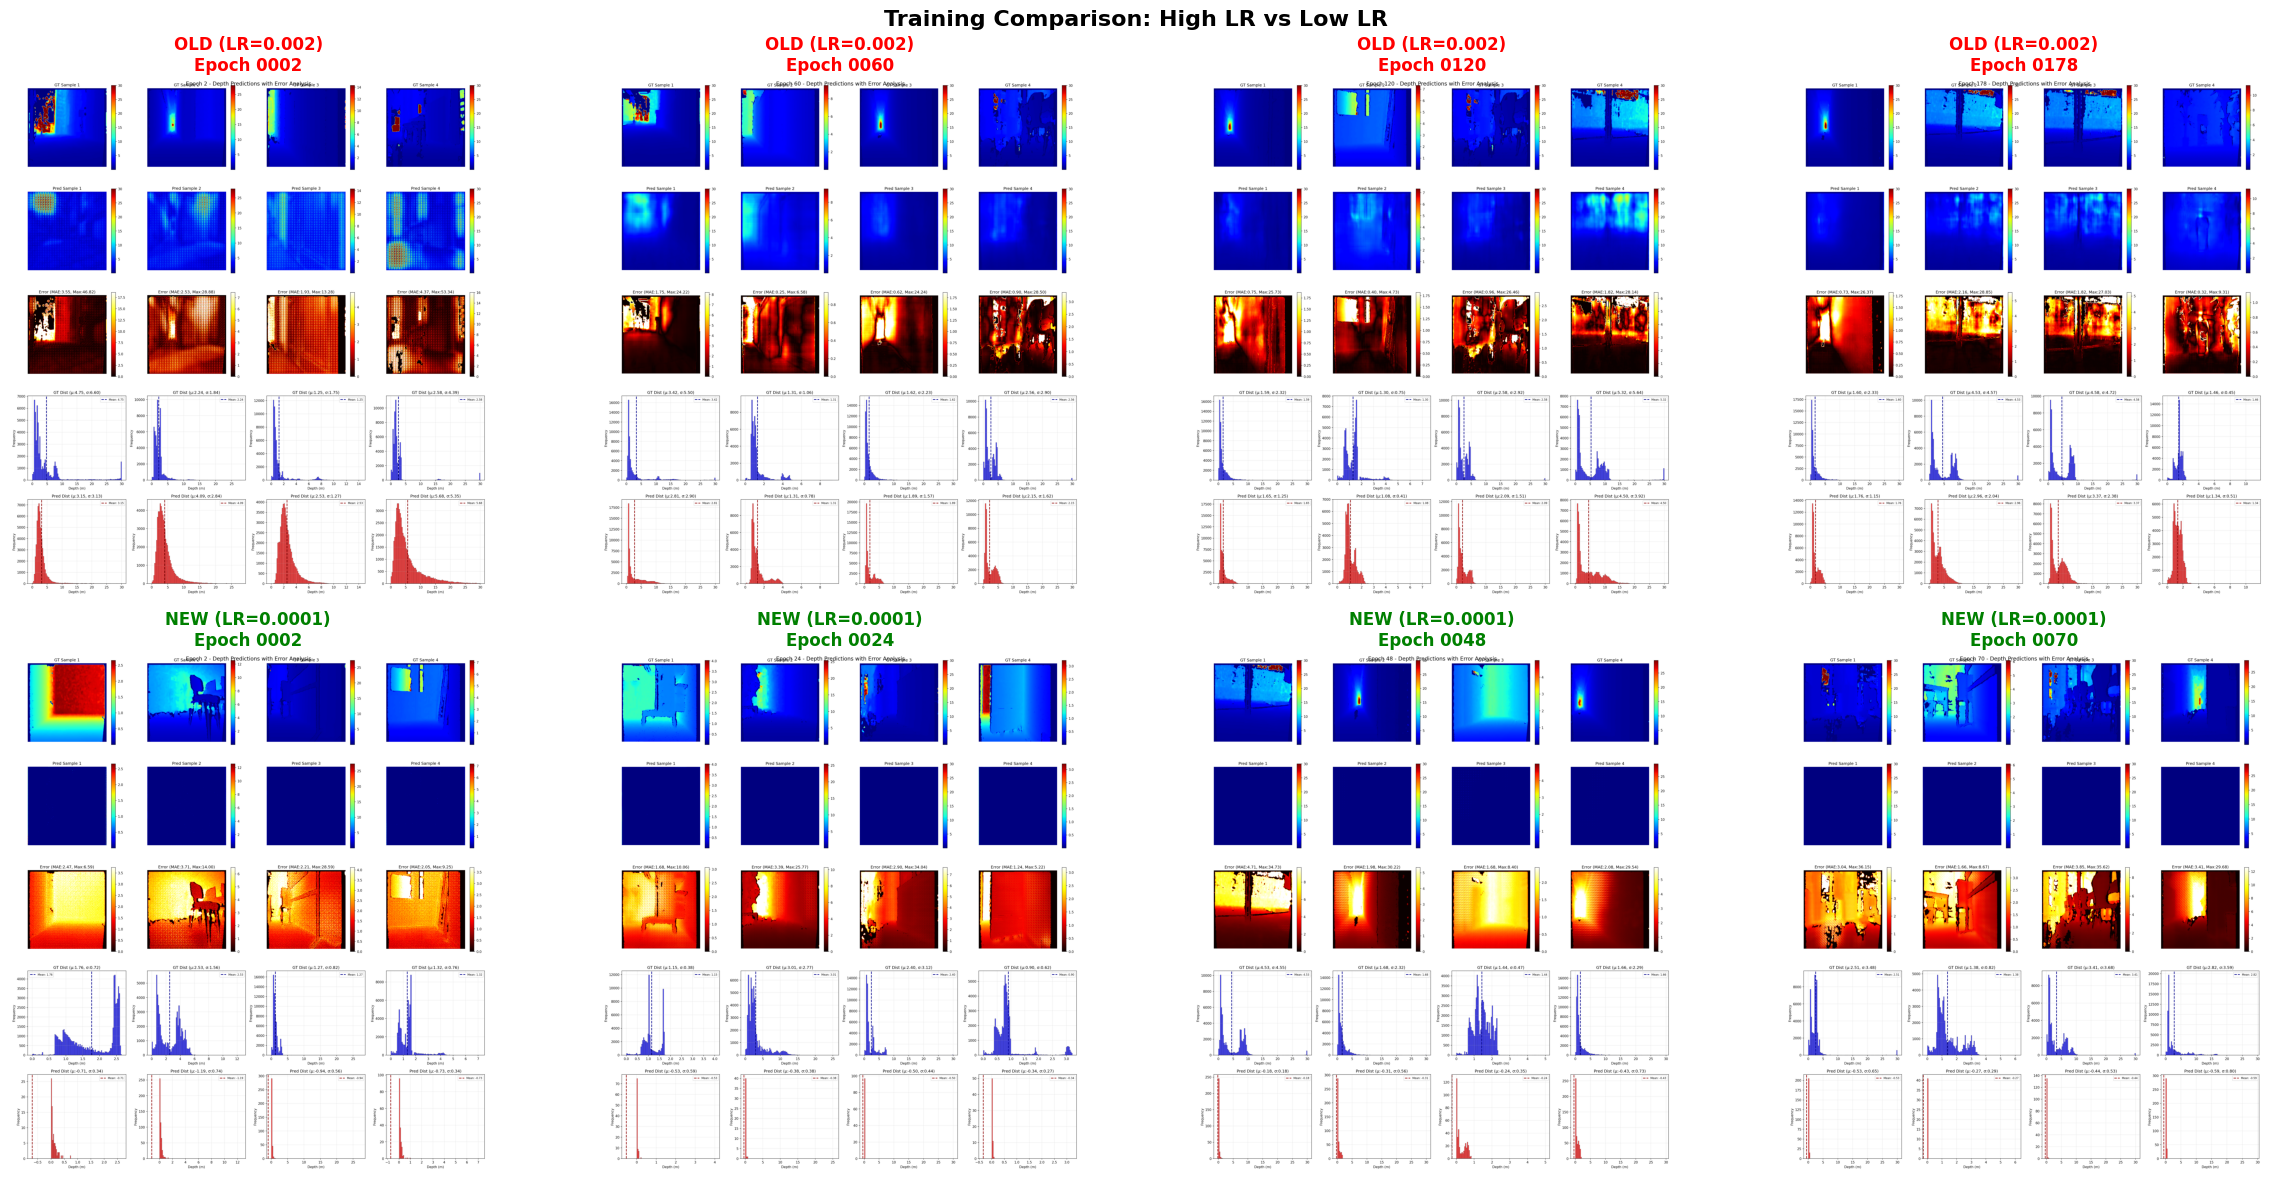


✅ Old training epochs: ['0002', '0060', '0120', '0178']
✅ New training epochs: ['0002', '0024', '0048', '0070']


In [8]:
# Compare old vs new training results visually
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

old_results = Path('/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly/results/unet_256_batvisionv2_BS256_Lr0.002_AdamW_IMG_img_baseline')
new_results = Path('/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly/results/unet_256_batvisionv2_BS32_Lr0.0001_AdamW_IMG_img_lr0.0001_v2')

# Get validation images
old_images = sorted(old_results.glob('epoch_*_validation.png'))
new_images = sorted(new_results.glob('epoch_*_validation.png'))

print(f"Old training (LR=0.002): {len(old_images)} validation images")
print(f"New training (LR=0.0001): {len(new_images)} validation images")

if len(old_images) > 0 and len(new_images) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    
    # Old training: early, middle, late epochs
    old_epochs_to_show = [0, len(old_images)//3, 2*len(old_images)//3, -1]
    new_epochs_to_show = [0, len(new_images)//3, 2*len(new_images)//3, -1]
    
    for idx, epoch_idx in enumerate(old_epochs_to_show):
        if epoch_idx < len(old_images):
            img_path = old_images[epoch_idx]
            img = mpimg.imread(img_path)
            epoch_num = img_path.stem.split('_')[1]
            
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'OLD (LR=0.002)\nEpoch {epoch_num}', 
                                   fontsize=12, fontweight='bold', color='red')
            axes[0, idx].axis('off')
    
    for idx, epoch_idx in enumerate(new_epochs_to_show):
        if epoch_idx < len(new_images):
            img_path = new_images[epoch_idx]
            img = mpimg.imread(img_path)
            epoch_num = img_path.stem.split('_')[1]
            
            axes[1, idx].imshow(img)
            axes[1, idx].set_title(f'NEW (LR=0.0001)\nEpoch {epoch_num}', 
                                   fontsize=12, fontweight='bold', color='green')
            axes[1, idx].axis('off')
    
    plt.suptitle('Training Comparison: High LR vs Low LR', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Old training epochs: {[old_images[i].stem.split('_')[1] for i in old_epochs_to_show if i < len(old_images)]}")
    print(f"✅ New training epochs: {[new_images[i].stem.split('_')[1] for i in new_epochs_to_show if i < len(new_images)]}")
else:
    print("⚠️  Not enough validation images to compare")
